## Introduction

The aim of this code is to develop a model recognizing signs from one to ten, with a simple CNN graphic training model. Our final form of data are plots with 6 lines, representing movements of five fingers and the palm from fist to the sign.

The original data is from https://github.com/MEICLabFZU/Gesture-Recognition-based-on-IMU

In [14]:
import torchvision
import sys,os
sys.path.append(os.pardir)
import glob as glob
import numpy as np

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

### Convert all data into plots

Our initial data are text files with numbers only. A final graph of the sign process are made from 12 text files that two of them generates the x-value and y-value of one line.

Thus we need:

- a function to delete all empty rows at the last of text files

- a function to convert numbers in the text file to a numpy array

In [16]:
def remove_last_line(l=[""]):
    while l[-1]=="":
        l.remove(l[-1])
        
    return l

In [17]:
def txt_to_array(xn=""):
    x1=open(xn,"rb")
    lx = x1.read().splitlines()
    str_lx=[x.decode('utf-8-sig') for x in lx]
    str_lx=remove_last_line(str_lx)
    lx_=np.float_(str_lx)
    return(lx_)

Each 12 files representing one movement are saved in the same directory, and then in the directory with "sign_pack" which sign is what the data standing for. 

Then the process to convert 12 texts in one folder into a simgle graph is simple. All we need to do is to iterate each folder under one directory until we finished plotting all data for all sign.

In [18]:
path="C:\\Users\\yexue\\Gesture-Recognition-based-on-IMU\\data\\rawdata_0"
fig_path="C:\\Users\\yexue\\Gesture-Recognition-based-on-IMU\\data\\figs_0\\"

### Peep look into the original and the final data

As shown below, the original data is in the form of a text file represent data on one axis of a line in a single plot. For example, following code printed the first 20 lines of data on x-axis of fore finger movement when showing eight.

In [45]:
# only show first 20 lines of the text file
x=open(os.path.join(path,"eight_pack\\eight\\fore-eight-x-1.txt"),"r")
list_x=x.read().splitlines()
print(len(list_x))
list_x[:20]

404


['183.53',
 '183.18',
 '183.19',
 '183.8',
 '181.96',
 '181.34',
 '183.49',
 '182.8',
 '183.57',
 '182.13',
 '183.48',
 '182.61',
 '182.76',
 '183.71',
 '182.32',
 '183.86',
 '184.11',
 '184.39',
 '183.46',
 '181.08']

In [19]:
# create a directory
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)
    fig_path=os.path.join(fig_path,"train")
    os.mkdir(fig_path)
    
# the list to store all folder for different signs under the initial path
signList=os.listdir(path)

for sign in signList:
    sp=os.path.join(fig_path,sign)
    if not os.path.isdir(sp):
        os.mkdir(sp) # make directory for each sign to save plots
    sign_path=os.path.join(path,sign)
    
    packs=os.listdir(sign_path)
    for pack in packs: # for each pack of one sign, generate the plot respectively
        pack_path=os.path.join(sign_path,pack)
        file_names=glob.glob(os.path.join(pack_path,"*.txt"))
        for i in range(6):
            xn=file_names[2*i]
            yn=file_names[2*i+1]

            lx_=txt_to_array(xn)
            ly_=txt_to_array(yn)

            if len(lx_)==len(ly_):
                plt.plot(lx_,ly_)
        #plt.savefig(os.path.join(fig_path,sign,str(pack))+".jpg")
        lis=re.findall(r'[0-9]+|[a-z]+',pack)
        if len(lis)==1:
            lis.append("1")
        fig=".".join(lis)
        plt.savefig(os.path.join(fig_path,sign,fig)+".jpg")
        plt.clf() # clear matplotlib space
        #print(pack)
    print(str(sign)+" done!")



eight_pack done!
five_pack done!
four_pack done!
nine_pack done!
one_pack done!
seven_pack done!
six_pack done!
ten_pack done!
three_pack done!
two_pack done!


<Figure size 432x288 with 0 Axes>

The generated plots looks as follows that each color represents movement of one part of the hand. This is the an example of sign eight.

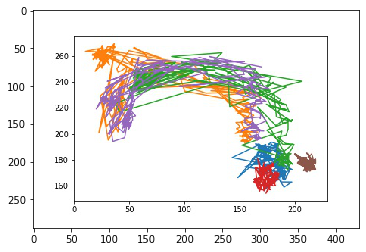

In [54]:
import cv2
packs=os.listdir(os.path.join(fig_path,"eight_pack"))
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join(fig_path,"eight_pack\\eight.1.jpg"))
imgplot = plt.imshow(img)
plt.show()

### Using pytorch to analyze the plots

We have generated the plots of sign movement. In order to make and train the model, this step is to devide the data into "train" and "valid" parts. Since our data size is quite small (about 22 plots for each sign), train size:valid size is approximately 2:1, which is not a usual ratio for such training.

First we import all packages.

In [2]:
#pytorch

import glob as glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

import math

To split the data into train data and valid data, we shuffle first and then take the first one third of all.

In [3]:
path = "C:\\Users\\yexue\\Gesture-Recognition-based-on-IMU\\data\\figs_0\\"
train_path=os.path.join(path,"train")
packs=os.listdir(train_path)
if not os.path.isdir(os.path.join(path,'valid')):
    os.mkdir(os.path.join(path,'valid'))

In [4]:
for pack in packs:
    #print(pack)
    files=glob.glob(os.path.join(train_path,pack,"*.jpg"))
    #print(os.path.join(train_path,pack,"*.jpg"))
    num = len(files)
    valid_size = math.floor(num/3)
    shuffle = np.random.permutation(num)
    #print(shuffle)
    
    valid_path=os.path.join(path,'valid')
    if not os.path.isdir(valid_path):
        os.mkdir(valid_path)
    os.mkdir(os.path.join(valid_path,pack))
    
    for i in shuffle[0:valid_size]:
        folder = files[i].split('\\')[-1].split('.')[0]
        image = files[i].split('\\')[-1]
        os.rename(files[i],os.path.join(path,'valid',folder+"_pack",image))
    

Model construction and training part. (Refer from an example to classify dogs and cats.)

In [7]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder(train_path,simple_transform)
valid = ImageFolder(valid_path,simple_transform)

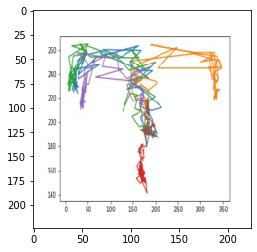

In [8]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
   
imshow(valid[50][0])

In [9]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=5,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=5,shuffle=True)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [11]:
model = Net()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [12]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
#         if is_cuda:
#             data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [13]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,30):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\yexue\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   2.3 and training accuracy is 22/147     14.97
validation loss is   2.3 and validation accuracy is 7/72     9.722
training loss is   2.3 and training accuracy is 26/147     17.69
validation loss is   2.2 and validation accuracy is 18/72      25.0
training loss is   2.2 and training accuracy is 42/147     28.57
validation loss is   2.1 and validation accuracy is 29/72     40.28
training loss is   1.9 and training accuracy is 49/147     33.33
validation loss is   1.8 and validation accuracy is 35/72     48.61
training loss is   1.8 and training accuracy is 58/147     39.46
validation loss is   1.5 and validation accuracy is 38/72     52.78
training loss is   1.9 and training accuracy is 59/147     40.14
validation loss is   1.4 and validation accuracy is 40/72     55.56
training loss is   1.4 and training accuracy is 78/147     53.06
validation loss is   1.3 and validation accuracy is 39/72     54.17
training loss is   1.3 and training accuracy is 80/147     54.42
valid

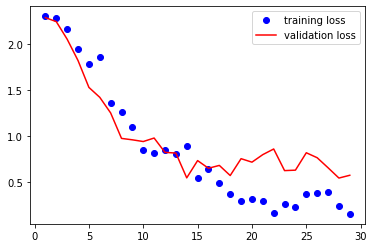

In [14]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

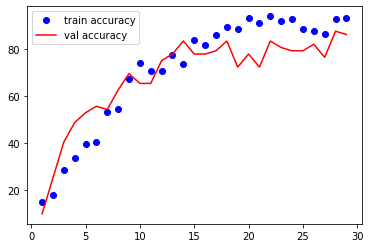

In [15]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()